# Tutorial: Training U-Net Models for gap filling


In [1]:
import numpy as np
import dask.array as da
import xarray as xr
import zarr

from os import path

import matplotlib.pyplot as plt

import tensorflow as tf
from keras import Input
import keras.layers as layers
from keras.callbacks import EarlyStopping

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mindthegap as mtg

2025-08-21 17:26:17.065371: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-21 17:26:17.079910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-21 17:26:17.097791: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-21 17:26:17.103245: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-21 17:26:17.116283: I tensorflow/core/platform/cpu_feature_guar

### Check for Available GPUs

When training ConvLSTM models, using a GPU can significantly speed up the training process compared to using a CPU. The following code checks if your environment includes a GPU and uses it for training if available.  By default, TensorFlow will use the available GPU for training.


In [2]:
# list all the physical devices
physical_devices = tf.config.list_physical_devices()
print("All Physical Devices:", physical_devices)

# list all the available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

# Print infomation for available GPU if there exists any
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print("GPU Details:", details)
else:
    print("No GPU available")

All Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Details: {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


In [3]:
datadir = "/home/jovyan/shared-public/mindthegap/data"

## Load the standardized data
This has the sin and cos features, the masks for fake clouds, real clouds, valid pixels, and all the predictor features.

The data were standardized based on train dataset (mean and standard deviation). Only numerical features and the label are standardized. Mean and standard deviation of _CHL_ and _masked_CHL_ are stored in a `.npy` file. 

In [3]:
# vars
datafeatures = ['sst']
train_year = 2015
train_range = 3
val_range = 1
test_range = 1

In [4]:
import xarray as xr
import zarr
datadir = "/home/jovyan/shared-public/mindthegap/data"
zarr_label="2015_3_ArabSea_Eli"
zarr_stdized = xr.open_zarr(f'{datadir}/{zarr_label}.zarr')
ds_cropped = crop_to_multiple(zarr_stdized, multiple=8)
ds_cropped

<xarray.Dataset> Size: 18GB
Dimensions:          (time: 16071, lat: 105, lon: 153)
Coordinates:
  * lat              (lat) float32 420B 31.0 30.75 30.5 30.25 ... 5.5 5.25 5.0
  * lon              (lon) float32 612B 42.0 42.25 42.5 ... 79.5 79.75 80.0
  * time             (time) datetime64[ns] 129kB 1979-01-01 ... 2022-12-31
Data variables:
    CHL              (time, lat, lon) float32 1GB dask.array<chunksize=(100, 105, 153), meta=np.ndarray>
    cos_time         (time, lat, lon) float32 1GB dask.array<chunksize=(100, 105, 153), meta=np.ndarray>
    fake_cloud_flag  (time, lat, lon) float64 2GB dask.array<chunksize=(100, 105, 153), meta=np.ndarray>
    land_flag        (time, lat, lon) float64 2GB dask.array<chunksize=(100, 105, 153), meta=np.ndarray>
    masked_CHL       (time, lat, lon) float32 1GB dask.array<chunksize=(100, 105, 153), meta=np.ndarray>
    next_day-CHL     (time, lat, lon) float64 2GB dask.array<chunksize=(100, 105, 153), meta=np.ndarray>
    prev_day_CHL     (time, lat, lon) float64 2GB dask.array<chunksize=(100, 105, 153), meta=np.ndarray>
    real_cloud_flag  (time, lat, lon) float64 2GB dask.array<chunksize=(100, 105, 153), meta=np.ndarray>
    sin_time         (time, lat, lon) float32 1GB dask.array<chunksize=(100, 105, 153), meta=np.ndarray>
    sst              (time, lat, lon) float32 1GB dask.array<chunksize=(100, 105, 153), meta=np.ndarray>
    valid_CHL_flag   (time, lat, lon) float64 2GB dask.array<chunksize=(100, 105, 153), meta=np.ndarray>

#### Function: `data_split`
This function selects the train, validation, and test data from the standardized data and splits the features and label.
##### Parameters:
- `zarr_stdized`: Zarr file storing standardized features and label.
- `train_year`: the first year of train data
- `train_range`: length of train data in year
- `val_range`: length of validation data in year
- `test_range`: length of test data in year
##### Return:
- `X_train, X_val, X_test`: the predictor variables of the train/validation/test data
- `y_train, y_val, y_test`: the response variables of the train/validation/test data

In [5]:
def data_split(zarr_stdized, train_year, train_range, val_range, test_range):
    X_vars = list(zarr_stdized.keys())
    X_vars.remove('CHL')
    
    zarr_train = zarr_stdized.sel(time=slice(f'{train_year}-01-01', f'{train_year+train_range}-01-01'))
    X_train = []
    for var in X_vars:
        var = zarr_train[var].to_numpy()
        X_train.append(np.where(np.isnan(var), 0.0, var))
    y_train = zarr_train.CHL.to_numpy()
    y_train = np.where(np.isnan(y_train), 0.0, y_train)
    X_train = np.array(X_train)
    X_train = np.moveaxis(X_train, 0, -1)
    del zarr_train
    
    zarr_val = zarr_stdized.sel(time=slice(f'{train_year+train_range}-01-01', f'{train_year+train_range+val_range}-01-01'))
    X_val = []
    for var in X_vars:
        var = zarr_val[var].to_numpy()
        X_val.append(np.where(np.isnan(var), 0.0, var))
    y_val = zarr_val.CHL.to_numpy()
    y_val = np.where(np.isnan(y_val), 0.0, y_val)
    X_val = np.array(X_val)
    X_val = np.moveaxis(X_val, 0, -1)
    del zarr_val
    
    zarr_test = zarr_stdized.sel(time=slice(f'{train_year+train_range+val_range}-01-01', f'{train_year+train_range+val_range+test_range}-01-01'))
    X_test= []
    for var in X_vars:
        var = zarr_test[var].to_numpy()
        X_test.append(np.where(np.isnan(var), 0.0, var))
    y_test = zarr_test.CHL.to_numpy()
    y_test = np.where(np.isnan(y_test), 0.0, y_test)
    X_test = np.array(X_test)
    X_test = np.moveaxis(X_test, 0, -1)
    del zarr_test, var

    return (X_train, y_train, 
            X_val, y_val,
            X_test, y_test)

In [14]:
X_train, y_train, X_val, y_val, X_test, y_test = data_split(ds_cropped, train_year, train_range, val_range, test_range)

In [15]:
X_train.shape

(1097, 104, 152, 10)

### 3. Build model: U-Net
#### What is U-Net?
U-Net is a Convolutional Neural Network (CNN) architecture. CNN is a type of deep learning model that is particularly effective for visual data and high dimensional data analysis. It is powerful in capturing spatial hierarchies and patterns, and is widely used in computer vision tasks.
U-Net follows an autoencoder architecture, where the encoder half down-samples input images progressively and extracts features, while the decoder half constructs predictions based on these features. It is effective and accurate with rather limited data.

#### Model Architectures
The model uses three encoder layers of filter sizes 64, 128, 256, and three decoder layers of filter sizes 128, 64, 1. Each encoder block consists of two `Conv2D` layers, one `MaxPool2D` layer, and one `BatchNormalization` layer. Each decoder block consists of one `Conv2DTranspose` layer, one `Concatenate` layer, two `Conv2D` layer, and one `BatchNormalization` layer. The output of the final decoder layer is the gap-filled prediction of Chl-a.
- `Conv2D`: applies 2D convolution operations to the input. These layers are for feature detection (lines, edges, objects, patterns, etc.) in the encoder half, and for making predictions in the decoder half.
  `filters`: number of output channels and the number of features detected.
  `kernel_size`: size of the filters. All filters in this model are of size 3x3.
  `padding`: adds extra pixels to the input images. Padding of `same` ensures the same output dimensions as the input.
  `activation`: introduces non-linearity to neural networks that differentiate NNs from linear models. All layers other than the final layer uses 'ReLU', which outputs the input directly if positive and 0 if non-positive. The final layer uses 'Linear' due to potential negative values in log(Chl-a) predictions.
- `MaxPooling2D`: downsamples the input by taking the maximum in a given window (default is 2x2). It reduces complexity for future computations while retaining the most significant features. The output dimension is half of the input.
- `BatchNormalization`: normalizes the input. It reduces overfitting and improves the generalizability of a model.
- `Conv2DTranspose`: performs a "reverse" convolution and upsamples the input. The output dimension doubles the input.
- `Concatenate`: merges the upsampled feature maps with the feature maps from the corresponding encoder. It retains the higher-resolution features that were lost during downsampling.

#### Model Compilation
We use `.compile()` to configure the model for training.
`optimizer`: adjusts the parameters of the model during training to minimize the loss. We use `Adam`, which is known for faster convergence with its adaptively adjustment of the learning rate.
`loss`: define the loss function the model aims to minimize. We use mean squared error (MSE) due to its simplicity and effectiveness in the task.
`metrics`: other metrics, such as error or accuracy, we wish to evaluate during training. We apply mean absolute error (MAE) as another evaluator for performance.

In [16]:
def UNet(input_shape):
    inputs = Input(shape=input_shape)
    
    x = inputs

    filters = [64, 128, 256]
    ec_images = []

    for filter in filters:
        ec_images.append(x)
        x = layers.Conv2D(filters=filter, 
                          kernel_size=(3, 3),  
                          padding='same',
                          activation='relu'
                         )(x)
        x = layers.Conv2D(filters=filter, 
                          kernel_size=(3, 3),  
                          padding='same',
                          activation='relu'
                         )(x)
        x = layers.MaxPooling2D()(x)
        x = layers.BatchNormalization()(x)

    for filter, ec_image in zip(filters[:-1][::-1], ec_images[::-1][:-1]):
        # x = layers.Conv2DTranspose(filter, 3, 2, padding='same')(x)
        x = layers.Conv2DTranspose(filter, 3, 2, padding='same')(x)
        
        x = layers.concatenate([x, ec_image])
        x = layers.Conv2D(filters=filter, 
                         kernel_size=(3, 3),  
                         padding='same',
                         activation='relu'
                         )(x)
        x = layers.Conv2D(filters=filter, 
                         kernel_size=(3, 3),  
                         padding='same',
                         activation='relu'
                         )(x)
        x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(filter, 3, 2, padding='same')(x)
    x = layers.concatenate([x, ec_images[0]])
    x = layers.Conv2D(filters=filter, 
                         kernel_size=(3, 3),  
                         padding='same',
                         activation='relu'
                         )(x)
    outputs = layers.Conv2D(filters=1,
                      kernel_size=(3,3),
                      padding='same',
                      activation='linear'
                     )(x)

    unet_model = tf.keras.Model(inputs, outputs, name='U-net')
    unet_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return unet_model

In [17]:
input_shape = X_train.shape[1:]
model = UNet(input_shape)
model.summary()

Model: "U-net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 104, 152,  │          0 │ -                 │
│ (InputLayer)        │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 104, 152,  │      5,824 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 104, 152,  │     36,928 │ conv2d_10[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 52, 76,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 76,    │        256 │ max_pooling2d_3[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 52, 76,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 52, 76,    │    147,584 │ conv2d_12[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 26, 38,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 38,    │        512 │ max_pooling2d_4[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 26, 38,    │    295,168 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 26, 38,    │    590,080 │ conv2d_14[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 13, 19,    │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 19,    │      1,024 │ max_pooling2d_5[… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 26, 38,    │    295,040 │ batch_normalizat… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 26, 38,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 26, 38,    │    295,040 │ concatenate_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 26, 38,    │    147,584 │ conv2d_16[0][0] 

 Total params: 2,154,369 (8.22 MB)

 Trainable params: 2,153,089 (8.21 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [18]:
X_train.shape[1:]

(104, 152, 10)

#### Model training
We use `tf.data.Dataset.from_tensor_slices()` to shuffle the train data and slice the train and validation data according the provided batch size.
We then define earlystopping that will stop the training process if the performance is not improving, and then start fitting the model. The MSE and MAE are printed for each training epoch, and their values are recorded by `history`.

In [19]:
# process train
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=512).batch(4)

In [20]:
# process val
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(4)

In [21]:
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[early_stop])

Epoch 1/50


2025-08-21 17:50:30.603102: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-21 17:50:31.132882: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300


  3/275 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.2764 - mae: 0.3760    

2025-08-21 17:50:41.161916: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_10', 256 bytes spill stores, 256 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_9', 72 bytes spill stores, 72 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion', 256 bytes spill stores, 256 bytes spill loads



275/275 ━━━━━━━━━━━━━━━━━━━━ 36s 73ms/step - loss: 0.0639 - mae: 0.1283 - val_loss: 0.0199 - val_mae: 0.0544
Epoch 2/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0134 - mae: 0.0466 - val_loss: 0.0138 - val_mae: 0.0456
Epoch 3/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0107 - mae: 0.0382 - val_loss: 0.0124 - val_mae: 0.0409
Epoch 4/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0096 - mae: 0.0343 - val_loss: 0.0123 - val_mae: 0.0424
Epoch 5/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0095 - mae: 0.0330 - val_loss: 0.0135 - val_mae: 0.0439
Epoch 6/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0087 - mae: 0.0313 - val_loss: 0.0115 - val_mae: 0.0361
Epoch 7/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.0086 - mae: 0.0298 - val_loss: 0.0101 - val_mae: 0.0327
Epoch 8/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.0066 - mae: 0.0233 - val_loss: 0.0088 - val_mae: 0.0288
Epoch 16/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - lo

#### Visualize losses
__Function__ `plot_losses`: Takes history as a parameter and plots the train and validation errors vs number of epochs (number of iterations for model training). This model evaluates the mean squared error and mean absolute error. 

In [22]:
def plot_losses(history):
    history_keys = list(history.history.keys())
    plot_num = len(history_keys) // 2
    plt.figure(figsize=(5 * plot_num, 4))
    for i in range(plot_num):
        plt.subplot(1, plot_num, i + 1)
        train_key = history_keys[i]
        val_key = history_keys[i + plot_num]
        plt.plot(history.history[train_key], label=f'Train {train_key}')
        plt.plot(history.history[val_key], label=f'Validation {val_key[4:]}')
        plt.title(train_key)
        plt.xlabel('Epoch')
        plt.ylabel(train_key)
        plt.legend(loc='upper right')
        plt.grid(True)
    plt.show()

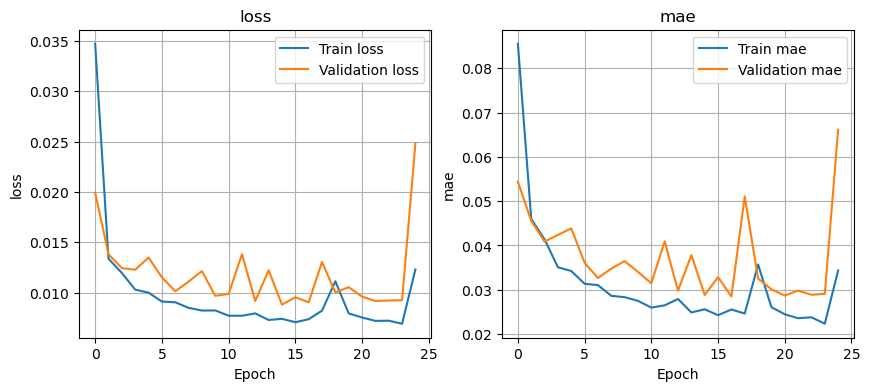

In [23]:
plot_losses(history)

#### Save trained model
The trained model is saved using `model.save` for easy access in future evaluation.
__Note__: Feel free to change the model path, but remember to create the folders before saving, or otherwise it may throw an error.

In [26]:
model_name = 'UNet_DoubleConv_mse'
import os
folder_path= f'models/{zarr_label}'
os.makedirs(folder_path, exist_ok=True)
model_path = f'models/{zarr_label}/{model_name}.keras'
model.save(model_path)

#### Reload trained model
If you want to reload a specific model, use `tf.kera.models.load_model` along with the path to the model.

In [11]:
import tensorflow as tf
model = tf.keras.models.load_model(f'models/{zarr_label}/{model_name}.keras')

2024-08-15 21:59:47.626092: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14782 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5


### 4. Model Evaluation
#### Evaluate test losses
__Function `test_loss`__: Takes the model and the test dataset as parameters and evaluates the model's performance. We use `model.evaluate` for performance of the model on unseen (test) dataset. The evaluation process calculates all loss and metrics compiled to the model (MAE and MSE in this case).

In [27]:
def test_loss(X_test, y_test, model, print_loss=True):
    # Prepare test dataset
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_dataset = test_dataset.batch(4)

    # Evaluate the model on the test dataset
    test_mse, test_mae = model.evaluate(test_dataset)
    if print_loss:
        print(f"Test MSE: {test_mse}")
        print(f"Test MAE: {test_mae}")
    return test_mse, test_mae

In [28]:
test_mse, test_mae = test_loss(X_test, y_test, model)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0110 - mae: 0.0375
Test MSE: 0.010837583802640438
Test MAE: 0.03541838377714157


#### Helper functions
- `unstdize`: unstandardize a given image to the original distribution. Since we standardized all data before training, the predicted log(Chl-a) from the model is also standardized. We apply this function so that the predictions are more comparable to the observed and other gap-filling products.
- `compute_mae`: computes the mean absolute error between two nd-arrays with the same shape. We use this function to calculate the difference between observed and predicted, or predictions between different algorithms.
- `compute_mse`: similar to `compute_mae`, but calculates the mean squared error instead.

In [29]:
def unstdize(stdized_image, mean, stdev):
    return stdized_image * stdev + mean

def compute_mae(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return np.mean(np.abs(y_true[mask] - y_pred[mask]))

def compute_mse(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return np.mean((y_true[mask] - y_pred[mask]) ** 2)

# def mean_error(y_true, y_pred):
#     mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
#     return np.abs(np.mean(y_true[mask]) - np.mean(y_pred[mask]))

## Plot predictions
- `plot_prediction_observed`: predicts the observed log(chl-a) data of a given date. Plots a four-panel plot with the top left being the log observed data, top right being the flag, bottom left being the log prediction, and bottom right being the log difference. Log difference shows the percentage difference: blue/log(1) means the observed is about 2.7 times the prediction, red/log(-1) means the observed is about 37% of the prediction.

### Load original data
Will need for plotting.

In [48]:
import xarray as xr
zarr_ds = xr.open_dataset(
    "gcs://nmfs_odp_nwfsc/CB/mind_the_chl_gap/IO.zarr",
    engine="zarr",
    backend_kwargs={"storage_options": {"token": "anon"}},
    consolidated=True
)
lat_min, lat_max = 5, 31
lon_min, lon_max = 42, 80

import numpy as np
zarr_ds = zarr_ds.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min,lon_max))  # choose long and lat
zarr_ds = crop_to_multiple(zarr_ds, multiple=8)
zarr_ds

<xarray.Dataset> Size: 25GB
Dimensions:                       (time: 16071, lat: 104, lon: 152)
Coordinates:
  * lat                           (lat) float32 416B 31.0 30.75 ... 5.5 5.25
  * lon                           (lon) float32 608B 42.0 42.25 ... 79.5 79.75
  * time                          (time) datetime64[ns] 129kB 1979-01-01 ... ...
Data variables: (12/27)
    CHL                           (time, lat, lon) float32 1GB ...
    CHL_cmes-cloud                (time, lat, lon) uint8 254MB ...
    CHL_cmes-gapfree              (time, lat, lon) float32 1GB ...
    CHL_cmes-land                 (lat, lon) uint8 16kB ...
    CHL_cmes-level3               (time, lat, lon) float32 1GB ...
    CHL_cmes_flags-gapfree        (time, lat, lon) float32 1GB ...
    ...                            ...
    ug_curr                       (time, lat, lon) float32 1GB ...
    v_curr                        (time, lat, lon) float32 1GB ...
    v_wind                        (time, lat, lon) float32 1GB ...
    vg_curr                       (time, lat, lon) float32 1GB ...
    wind_dir                      (time, lat, lon) float32 1GB ...
    wind_speed                    (time, lat, lon) float32 1GB ...
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

In [30]:
def plot_prediction_observed(zarr_stdized, zarr_label, model, date_to_predict):
    mean_std = np.load(f'{datadir}/{zarr_label}.npy',allow_pickle='TRUE').item()
    mean, std = mean_std['CHL'][0], mean_std['CHL'][1]
    zarr_date = zarr_stdized.sel(time=date_to_predict)
    X = []
    X_vars = list(zarr_stdized.keys())
    X_vars.remove('CHL')
    for var in X_vars:
        var = zarr_date[var].to_numpy()
        X.append(np.where(np.isnan(var), 0.0, var))
    X = np.array(X)
    X = np.moveaxis(X, 0, -1)

    true_CHL = np.log(zarr_ds.sel(time=date_to_predict)['CHL_cmes-level3'].to_numpy())
    # true_CHL = unstdize(true_CHL, mean, std)
    fake_cloud_flag = zarr_date.fake_cloud_flag.to_numpy()
    masked_CHL = np.where(fake_cloud_flag == 1, np.nan, true_CHL)
    # masked_CHL = unstdize(masked_CHL, mean, std)
    predicted_CHL = model.predict(X[np.newaxis, ...], verbose=0)[0]
    predicted_CHL = predicted_CHL[:,:,0]
    predicted_CHL = unstdize(predicted_CHL, mean, std)
    predicted_CHL = np.where(np.isnan(true_CHL), np.nan, predicted_CHL)
    diff = true_CHL - predicted_CHL

    flag = np.zeros(true_CHL.shape)
    flag = np.where(zarr_date['land_flag'] == 1, 0, flag)
    flag = np.where(zarr_date['valid_CHL_flag'] == 1, 2, flag)
    flag = np.where(zarr_date['real_cloud_flag'] == 1, 0, flag)
    flag = np.where(zarr_date['fake_cloud_flag'] == 1, 1, flag)

    vmax = np.nanmax((true_CHL, predicted_CHL))
    vmin = np.nanmin((true_CHL, predicted_CHL))

    extent = [42, 101.75, -11.75, 32]
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    im0 = axes[0, 0].imshow(true_CHL, vmin=vmin, vmax=vmax, extent=extent, origin='upper', transform=ccrs.PlateCarree(), interpolation='nearest')
    axes[0, 0].add_feature(cfeature.COASTLINE)
    axes[0, 0].set_xlabel('longitude')
    axes[0, 0].set_ylabel('latitude')
    axes[0, 0].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[0, 0].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[0, 0].set_title('Observed Level-3 log Chl-a', size=14)
    
    im1 = axes[0, 1].imshow(flag, extent=extent, origin='upper', transform=ccrs.PlateCarree())
    axes[0, 1].add_feature(cfeature.COASTLINE, color='white')
    axes[0, 1].set_xlabel('longitude')
    axes[0, 1].set_ylabel('latitude')
    axes[0, 1].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[0, 1].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[0, 1].set_title('Land, Cloud, and Observed Flags After Applying Fake Cloud', size=13)
    
    im2 = axes[1, 0].imshow(predicted_CHL, vmin=vmin, vmax=vmax, extent=extent, origin='upper', transform=ccrs.PlateCarree(), interpolation='nearest') 
    axes[1, 0].add_feature(cfeature.COASTLINE, color='white')
    axes[1, 0].imshow(np.where(flag == 1, np.nan, flag), vmax=2, vmin=0, extent=extent, origin='upper', interpolation='nearest', alpha=1)
    axes[1, 0].set_xlabel('longitude')
    axes[1, 0].set_ylabel('latitude')
    axes[1, 0].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[1, 0].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[1, 0].set_title('Predicted log Chl-a from U-Net', size=14)

    vmin2 = -1
    vmax2 = 1
    im3 = axes[1, 1].imshow(diff, vmin=vmin2, vmax=vmax2, extent=extent, origin='upper', transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu, interpolation='nearest')
    axes[1, 1].add_feature(cfeature.COASTLINE)
    axes[1, 1].set_xlabel('longitude')
    axes[1, 1].set_ylabel('latitude')
    axes[1, 1].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[1, 1].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[1, 1].set_title('Difference Between log Observed and log Prediction\n(log observed - log prediction)', size=13)

    fig.subplots_adjust(right=0.76)
    cbar1_ax = fig.add_axes([0.79, 0.14, 0.025, 0.72])
    cbar1 = fig.colorbar(im0, cax=cbar1_ax)
    cbar1.ax.set_ylabel('log Chl-a (mg/m-3)', rotation=270, size=14, labelpad=16)

    cbar2_ax = fig.add_axes([0.86, 0.14, 0.025, 0.72])
    cbar2 = fig.colorbar(im1, cax=cbar2_ax)
    cbar2.ax.set_ylabel('land and real cloud = 0, fake cloud = 1, observed after masking = 2', rotation=270, size=14, labelpad=20)

    cbar3_ax = fig.add_axes([0.94, 0.14, 0.025, 0.72])
    cbar3 = fig.colorbar(im3, cax=cbar3_ax)
    cbar3.ax.set_ylabel('difference in log Chl-a', rotation=270, size=14, labelpad=16)
    plt.show()

/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


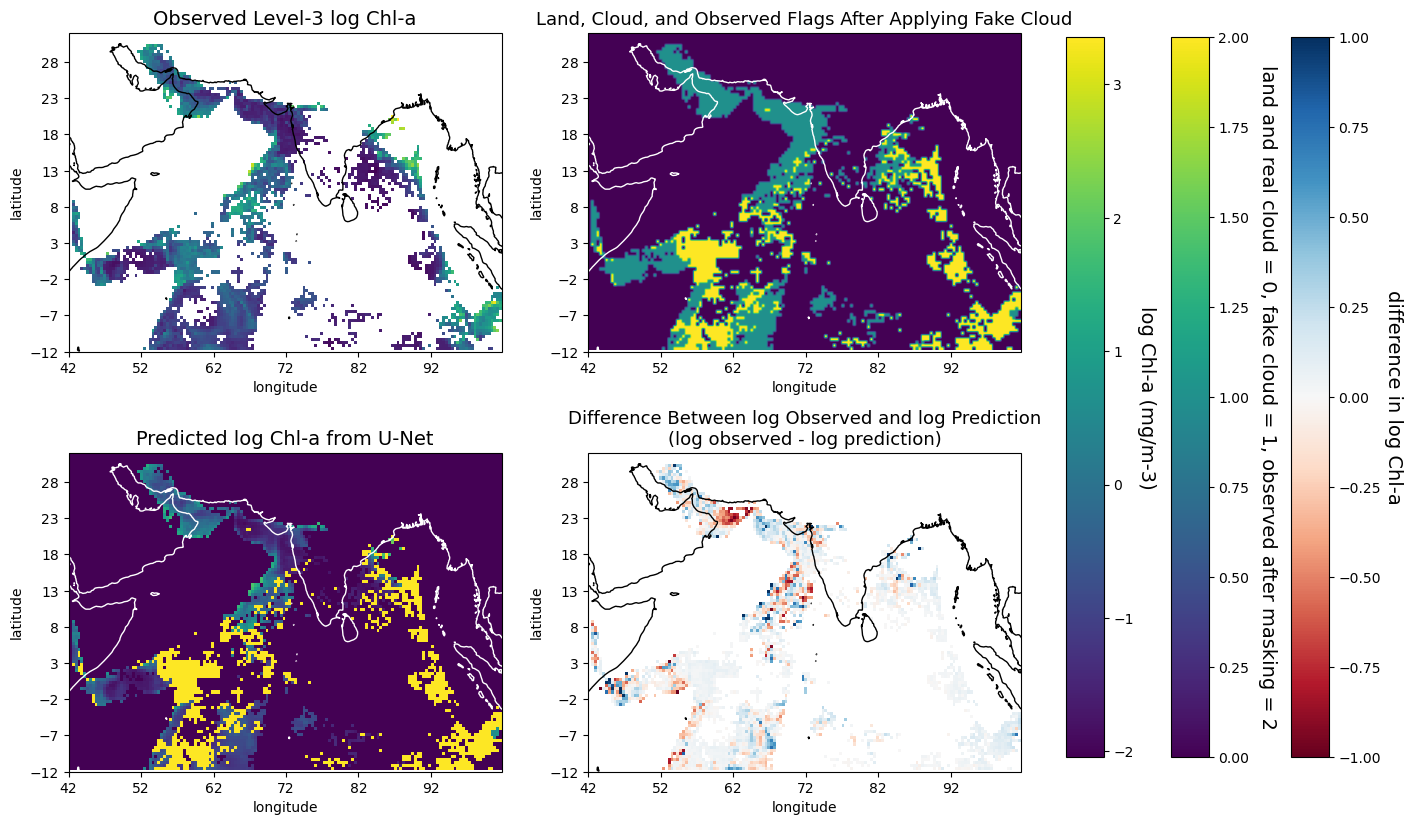

In [45]:
date = '2020-09-08'
plot_prediction_observed(ds_cropped, zarr_label, model, date)

- `plot_prediction_gapfill`:  predicts the gapfilled log(chl-a) of a given date. Plots a four-panel plot with the top left being the log gapfilled data from Copernicus GlobColour gapfree product, top right being the log U-Net prediction, bottom left being the log difference, and bottom right being the absolute difference.

In [46]:
def plot_prediction_gapfill(zarr_stdized, zarr_label, model, date_to_predict):
    mean_std = np.load(f'{datadir}/{zarr_label}.npy',allow_pickle='TRUE').item()
    mean, std = mean_std['CHL'][0], mean_std['CHL'][1]
    zarr_date = zarr_stdized.sel(time=date_to_predict)
    X = []
    X_vars = list(zarr_stdized.keys())
    X_vars.remove('CHL')
    X_vars[X_vars.index('masked_CHL')] = 'CHL'
    X_vars[X_vars.index('real_cloud_flag')] = 'a'
    X_vars[X_vars.index('fake_cloud_flag')] = 'real_cloud_flag'
    X_vars[X_vars.index('a')] = 'fake_cloud_flag'
    
    for var in X_vars:
        var = zarr_date[var].to_numpy()
        X.append(np.where(np.isnan(var), 0.0, var))
    valid_CHL_ind = X_vars.index('valid_CHL_flag')
    X[valid_CHL_ind] = da.where(X[X_vars.index('fake_cloud_flag')] == 1, 1, X[valid_CHL_ind])
    X[X_vars.index('fake_cloud_flag')] = np.zeros(X[0].shape)
    X_masked_CHL = np.log(zarr_ds.sel(time=date_to_predict)['CHL_cmes-level3'].to_numpy())
    X_masked_CHL = (X_masked_CHL - da.full(X_masked_CHL.shape, mean_std['masked_CHL'][0])) / da.full(X_masked_CHL.shape, mean_std['masked_CHL'][1])
    X_vars[X_vars.index('CHL')] = X_masked_CHL

    
    X = np.array(X)
    X = np.moveaxis(X, 0, -1)

    true_CHL = np.log(zarr_ds.sel(time=date_to_predict)['CHL_cmes-gapfree'].to_numpy())
    masked_CHL = np.log(zarr_ds.sel(time=date_to_predict)['CHL_cmes-level3'].to_numpy())
    predicted_CHL = model.predict(X[np.newaxis, ...], verbose=0)[0]
    predicted_CHL = predicted_CHL[:,:,0]
    predicted_CHL = unstdize(predicted_CHL, mean, std)
    predicted_CHL = np.where(np.isnan(true_CHL), np.nan, predicted_CHL)
    log_diff = true_CHL - predicted_CHL
    diff = np.exp(true_CHL) - np.exp(predicted_CHL)

    vmax = np.nanmax((true_CHL, predicted_CHL))
    vmin = np.nanmin((true_CHL, predicted_CHL))

    extent = [42, 101.75, -11.75, 32]
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    im0 = axes[0, 0].imshow(true_CHL, vmin=vmin, vmax=vmax, extent=extent, origin='upper', transform=ccrs.PlateCarree())
    # axes[0, 0].add_feature(cfeature.COASTLINE)
    axes[0, 0].set_xlabel('longitude')
    axes[0, 0].set_ylabel('latitude')
    axes[0, 0].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[0, 0].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[0, 0].set_title('Log Chl-a from the Gapfree \nLevel-4 GlobColour Copernicus Product', size=14)
    
    im1 = axes[0, 1].imshow(predicted_CHL, extent=extent, origin='upper', transform=ccrs.PlateCarree())
    axes[0, 1].set_xlabel('longitude')
    axes[0, 1].set_ylabel('latitude')
    axes[0, 1].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[0, 1].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[0, 1].set_title('Gapfree log Chl-a from U-Net', size=14)
    
    vmax2 = 1
    vmin2 = -1
    im2 = axes[1, 0].imshow(log_diff, vmin=vmin2, vmax=vmax2, extent=extent, origin='upper', transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu)
    # axes[1, 0].add_feature(cfeature.COASTLINE)
    axes[1, 0].set_xlabel('longitude')
    axes[1, 0].set_ylabel('latitude')
    axes[1, 0].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[1, 0].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[1, 0].set_title('Difference Between log Copernicus Product\nand log U-Net Prediction(log Copernicus - log U-Net)', size=13)

    im3 = axes[1, 1].imshow(diff, vmin=vmin2, vmax=vmax2, extent=extent, origin='upper', transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu)
    # axes[1, 1].add_feature(cfeature.COASTLINE)
    axes[1, 1].set_xlabel('longitude')
    axes[1, 1].set_ylabel('latitude')
    axes[1, 1].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[1, 1].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[1, 1].set_title('Absolute Difference Between Copernicus Product\nand U-Net Predictions(Copernicus - U-Net)', size=13)

    # fig.subplots_adjust(right=0.85)
    # cbar_ax = fig.add_axes([0.88, 0.2, 0.03, 0.6])
    # fig.colorbar(im, cax=cbar_ax)

    # cbar2_ax = fig.add_axes([0.95, 0.2, 0.03, 0.6])
    # fig.colorbar(im2, cax=cbar2_ax)

    fig.subplots_adjust(right=0.85)
    cbar1_ax = fig.add_axes([0.87, 0.14, 0.025, 0.72])
    # .ax.set_ylabel('# of contacts', rotation=270)
    cbar1 = fig.colorbar(im0, cax=cbar1_ax)
    cbar1.ax.set_ylabel('log Chl-a (mg/m-3)', rotation=270, size=14, labelpad=16)

    cbar2_ax = fig.add_axes([0.94, 0.14, 0.025, 0.72])
    # .ax.set_ylabel('# of contacts', rotation=270)
    cbar2 = fig.colorbar(im2, cax=cbar2_ax)
    cbar2.ax.set_ylabel('difference in Chl-a in log or absolute scales', rotation=270, size=14, labelpad=16)
    plt.subplots_adjust(top=0.96)
    plt.show()

In [47]:
plot_prediction_gapfill(zarr_stdized, zarr_label, model, date)

2025-08-21 18:14:21.811610: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at xla_ops.cc:577 : INVALID_ARGUMENT: Cannot concatenate arrays that differ in dimensions other than the one being concatenated. Dimension 1 in both shapes must be equal (or compatible): f32[1,104,152,64] vs f32[1,105,153,10].
	 [[{{node U-net_1/concatenate_5_1/concat}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_111402[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
2025-08-21 18:14:21.811649: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Cannot concatenate arrays that differ in dimensions other than the one being concatenated. Dimension 1 in both shapes must be equal (or compatible): f32[1,104,152,64] vs f32[1,105,153,10].
	 [[{{node U-net_1/concatenate_5_1/concat}}]]
	tf2xla conversion failed while converting __inference

InvalidArgumentError: Graph execution error:

Detected at node U-net_1/concatenate_5_1/concat defined at (most recent call last):
<stack traces unavailable>
Cannot concatenate arrays that differ in dimensions other than the one being concatenated. Dimension 1 in both shapes must be equal (or compatible): f32[1,104,152,64] vs f32[1,105,153,10].
	 [[{{node U-net_1/concatenate_5_1/concat}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_111402[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_data_distributed_111505]

#### Plot Year-round Mean Absolute Difference
Such plots help evaluate the performance of the model on a daily basis and visualize seasonal trends.
- `yearly_MAD`: plots a line plot of the daily MAD between the observed and the U-Net prediction of the observed in a given year. 

In [14]:
def yearly_MAD(zarr_stdized, zarr_label, year):
    mean_std = np.load(f'{datadir}/{zarr_label}.npy',allow_pickle='TRUE').item()
    mean, std = mean_std['CHL'][0], mean_std['CHL'][1]
    time_range = slice(f'{year}-01-01', f'{year}-12-31')
    zarr_time_range = zarr_stdized.sel(time=time_range)

    mae = []

    X = []
    X_vars = list(zarr_stdized.keys())
    X_vars.remove('CHL')
    for var in X_vars:
        var = zarr_time_range[var].to_numpy()
        X.append(np.where(np.isnan(var), 0.0, var))
    X = np.array(X)
    X = np.moveaxis(X, 0, -1)

    true_CHL = np.log(zarr_ds.sel(time=time_range)['CHL_cmes-level3'].to_numpy())
    fake_cloud_flag = zarr_time_range.fake_cloud_flag.to_numpy()
    predicted_CHL = model.predict(X, verbose=0)
    predicted_CHL = predicted_CHL.reshape(predicted_CHL.shape[:-1])
    predicted_CHL = unstdize(predicted_CHL, mean, std)
    predicted_CHL = np.where(fake_cloud_flag == 0, np.nan, predicted_CHL)
    for true, pred in zip(true_CHL, predicted_CHL):
        mae.append(compute_mae(true, pred))
    
    fig, ax1 = plt.subplots()
    
    color = 'tab:red'
    ax1.set_xlabel('Month')
    ax1.set_ylabel('MAD of log (Globcolour l3) - log (U-Net)', color=color)
    ax1.plot(mae, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    tick_pos = []
    tick_label = []
    total_day = 1
    tick_pos.append(total_day + 15)
    tick_label.append('1')
    for month in range(1, 12):
        total_day += calendar.monthrange(year, month)[1]
        plt.axvline(total_day, color='grey', alpha=0.3)
        tick_pos.append(total_day + 15)
        tick_label.append(str(month+1))
    plt.title(f'Observed (Level-3) CHL vs U-Net Predictions Year {year}')
    plt.xlim(1, len(mae))
    plt.xticks(tick_pos, tick_label)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


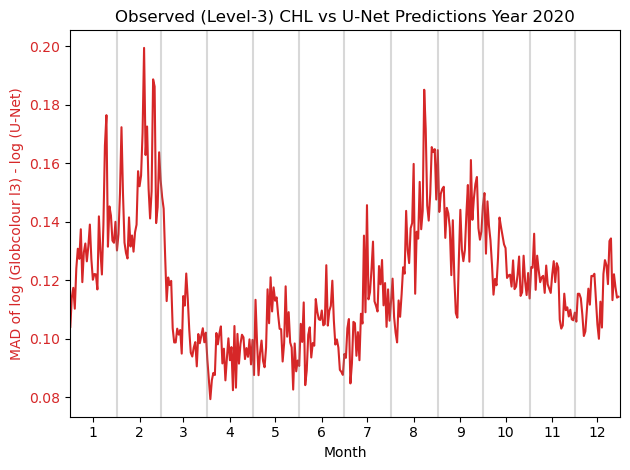

In [22]:
yearly_MAD(zarr_stdized, zarr_label, 2020)

- `yearly_MAD_vs_cloud`: plots a line plot with two lines: the red line is the daily MAD between the Copernicus Gapfree product and the U-Net's gapfree prediction in a given year, and the blue line is the daily percentage of cloud/missing data of the same year.
- `get_cloud_perc`: a helper function that gets the cloud percentage in a given year.|

In [23]:
def get_cloud_perc(zarr_stdized, year):
    zarr_time_range = zarr_stdized.sel(time=str(year))

    non_land_cnt = len(np.where(zarr_time_range['land_flag'][0] == 0)[0])
    clouds = zarr_time_range['real_cloud_flag'].data
    cloud_cnt = np.sum(clouds == 1, axis=(1, 2)).compute()
    cloud_perc = cloud_cnt / non_land_cnt

    return cloud_perc
    

def yearly_MAD_vs_cloud(zarr_stdized, zarr_label, model, year):
    mean_std = np.load(f'{datadir}/{zarr_label}.npy',allow_pickle='TRUE').item()
    mean, std = mean_std['CHL'][0], mean_std['CHL'][1]
    time_range = slice(f'{year}-01-01', f'{year}-12-31')

    zarr_time_range = zarr_stdized.sel(time=time_range)
    
    X = []
    X_vars = list(zarr_stdized.keys())
    X_vars.remove('CHL')
    X_vars[X_vars.index('masked_CHL')] = 'CHL'
    X_vars[X_vars.index('real_cloud_flag')] = 'a'
    X_vars[X_vars.index('fake_cloud_flag')] = 'real_cloud_flag'
    X_vars[X_vars.index('a')] = 'fake_cloud_flag'
    for var in X_vars:
        var = zarr_time_range[var].to_numpy()
        X.append(np.where(np.isnan(var), 0.0, var))
    valid_CHL_ind = X_vars.index('valid_CHL_flag')
    X[valid_CHL_ind] = da.where(X[X_vars.index('fake_cloud_flag')] == 1, 1, X[valid_CHL_ind]) 
    X[X_vars.index('fake_cloud_flag')] = np.zeros(X[0].shape)
    X_masked_CHL = np.log(zarr_ds.sel(time=time_range)['CHL_cmes-level3'].to_numpy())
    X_masked_CHL = (X_masked_CHL - da.full(X_masked_CHL.shape, mean_std['masked_CHL'][0])) / da.full(X_masked_CHL.shape, mean_std['masked_CHL'][1])
    X_vars[X_vars.index('CHL')] = da.where(da.isnan(X_masked_CHL), 0.0, X_masked_CHL)
    X = np.array(X)
    X = np.moveaxis(X, 0, -1)

    true_CHL = np.log(zarr_ds.sel(time=time_range)['CHL_cmes-gapfree'].to_numpy())            
    # fake_cloud_flag = zarr_date.fake_cloud_flag.to_numpy()
    predicted_CHL = model.predict(X, verbose=0)
    predicted_CHL = predicted_CHL.reshape(predicted_CHL.shape[:-1])
    predicted_CHL = unstdize(predicted_CHL, mean, std)
    flag = zarr_ds.sel(time=str(year))['CHL_cmes-level3'].to_numpy()
    predicted_CHL = np.where(~np.isnan(flag), np.nan, predicted_CHL)
    mae = []
    for true, pred in zip(true_CHL, predicted_CHL):
        mae.append(compute_mae(true, pred))
    
    cloud_perc = get_cloud_perc(zarr_stdized, year)
    
    fig, ax1 = plt.subplots()
    
    color = 'tab:red'
    ax1.set_xlabel('Month')
    ax1.set_ylabel('MAD of log (Globcolour l4) - log (U-Net)', color=color)
    ax1.plot(mae, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    
    color = 'tab:blue'
    ax2.set_ylabel('Cloud Percentage', color=color)  # we already handled the x-label with ax1
    ax2.plot(cloud_perc, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    tick_pos = []
    tick_label = []
    total_day = 1
    tick_pos.append(total_day + 15)
    tick_label.append('1')
    for month in range(1, 12):
        total_day += calendar.monthrange(year, month)[1]
        plt.axvline(total_day, color='grey', alpha=0.3)
        tick_pos.append(total_day + 15)
        tick_label.append(str(month+1))
    plt.title(f'Copernicus GlobColour Gapfree CHL vs U-Net Predictions\nMAD vs Cloud Percentage Year {year}')
    plt.xlim(1, len(mae))
    plt.xticks(tick_pos, tick_label)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

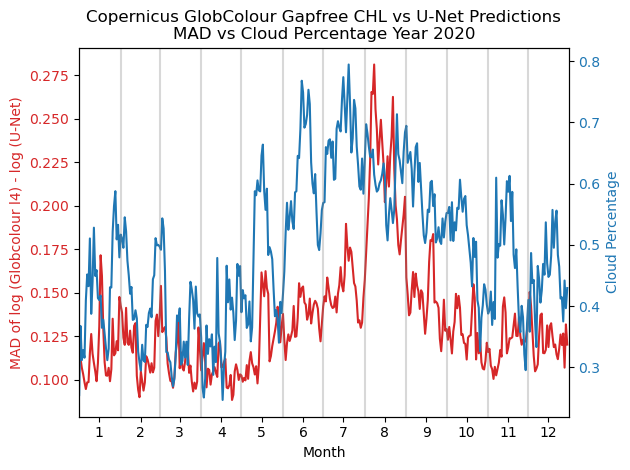

In [24]:
yearly_MAD_vs_cloud(zarr_stdized, zarr_label, model, 2020)